### Import necessary libraries

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import layers, models, optimizers

from stable_baselines3 import PPO
import gym
from gym import spaces

from sklearn.model_selection import train_test_split


### Define agent and expert dataset path

In [2]:
agent_dataset_path = "../../dataset/xray_new/COVID_19_Radiography_Dataset_Unseen/"
training_dataset_path = "../../dataset/xray_new/COVID_19_Radiography_Dataset_Refined/"

### Load previously trained expert model

In [3]:
# Load expert model
expert_model_name = "./models/xray_vgg16net_64_20_expert_acc_98.2.h5"
expert_model = load_model(expert_model_name)

In [4]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 20
BASE_MODELS = ["vgg16net", "resnet101", "densenet169"]
SEED = 123

In [5]:
agent_train_ds = image_dataset_from_directory(
  agent_dataset_path,
  validation_split=0.2,
  seed=SEED,
  subset="training",
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  shuffle=True
)

Found 4667 files belonging to 3 classes.
Using 3734 files for training.


In [6]:
agent_val_ds = image_dataset_from_directory(
  agent_dataset_path,
  validation_split=0.2,
  seed=SEED,
  subset="validation",
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  shuffle=True
)

Found 4667 files belonging to 3 classes.
Using 933 files for validation.


In [22]:
class_names = ['Normal', 'Pneumonia', 'COVID-19']
classes = agent_train_ds.class_names
print(classes)
NUM_CLASSES = len(classes)

['COVID', 'Normal', 'Viral Pneumonia']


In [7]:
agent_train_data = []
for agent_train_batch, _ in agent_train_ds:
    
    agent_train_data.extend((agent_train_batch/255.0).numpy())

agent_train_data = np.array(agent_train_data)

In [8]:
print(agent_train_data.shape)

(3734, 224, 224, 3)


In [9]:
expert_predictions_temp = expert_model.predict(agent_train_data)

117/117 [==============================] - 10s 45ms/step


In [10]:
expert_predictions = (expert_predictions_temp > 0.5).astype(int)
expert_predictions = [np.where(x == 1)[0][0] if np.where(x == 1)[0].size > 0 else 0 for x in expert_predictions]

In [11]:
# Define the imitation policy
class ImitationPolicy(tf.keras.Model):
    def __init__(self, input_shape, num_classes):
        super(ImitationPolicy, self).__init__()
        self.num_classes = num_classes
        # self.base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
        # self.flatten = Flatten()
        # self.output_layer = Dense(num_classes, activation='softmax')
        self.conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3))
        self.pool1 = MaxPooling2D(pool_size=(2, 2))
        self.conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')
        self.pool2 = MaxPooling2D(pool_size=(2, 2))
        self.flatten = Flatten()
        self.fc1 = Dense(128, activation='relu')
        self.fc2 = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # x = self.base_model(inputs)
        # x = self.flatten(x)
        # return self.output_layer(x)
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return self.fc2(x)


In [12]:
# Define the PPO agent
class PPOAgent:
    def __init__(self, input_shape, num_classes):
        self.policy_network = ImitationPolicy(input_shape, num_classes)
        self.policy_network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    def train_step(self, states, actions, advantages, old_probs):
        with tf.GradientTape() as tape:
            # Compute new action probabilities
            new_probs = self.policy_network(states)
            action_masks = tf.one_hot(actions, depth=self.policy_network.num_classes)
            selected_probs = tf.reduce_sum(action_masks * new_probs, axis=1)

            # Compute PPO loss
            ratio = selected_probs / old_probs
            clipped_ratio = tf.clip_by_value(ratio, 1 - ppo_clip_ratio, 1 + ppo_clip_ratio)
            surrogate1 = ratio * advantages
            surrogate2 = clipped_ratio * advantages
            policy_loss = -tf.reduce_mean(tf.minimum(surrogate1, surrogate2))
            

        # Compute gradients and apply updates
        gradients = tape.gradient(policy_loss, self.policy_network.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.policy_network.trainable_variables))
        


In [13]:
# Main training loop for imitation learning with PPO
def train_imitation_learning(env_name, num_episodes, X_train, y_train):
    state_shape = X_train.shape[1:]
    num_classes = len(np.unique(labels))
    
    # Generate expert demonstrations
    expert_demonstrations = []
    for _ in range(num_episodes):
        idx = np.random.choice(len(X_train))
        expert_demonstrations.append((X_train[idx], y_train[idx]))

    # Train PPO agent with imitation learning
    ppo_agent = PPOAgent(state_shape, num_classes)

    for _ in range(num_epochs):
        
        np.random.shuffle(expert_demonstrations)
        states, actions = zip(*expert_demonstrations)
        states = np.array(states)
        actions = np.array(actions)
        
        a2 = np.max(ppo_agent.policy_network.predict(states[:3]), axis=1)
        print(a2, actions[:3])
        old_probs = np.max(expert_model.predict(states), axis=1)

        ppo_agent.train_step(states, actions, advantages=np.ones_like(actions), old_probs=old_probs)
        
    return ppo_agent

In [14]:
env_name = 'CTSCAN-V1'
num_episodes = 100
num_epochs = 20
ppo_clip_ratio = 0.2

# Load data (replace this with your data loading code)
images, labels = agent_train_data, expert_predictions

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

ppo_agent = train_imitation_learning(env_name, num_episodes, X_train, y_train)

1/1 [==============================] - 1s 501ms/step
[0.38360885 0.36130738 0.39197233] [0 2 0]
1/1 [==============================] - 0s 21ms/step
[1. 1. 1.] [0 0 0]
1/1 [==============================] - 0s 20ms/step
[1. 1. 1.] [0 0 0]
1/1 [==============================] - 0s 20ms/step
[1. 1. 1.] [0 0 0]
1/1 [==============================] - 0s 19ms/step
[1. 1. 1.] [0 1 0]
1/1 [==============================] - 0s 20ms/step
[1. 1. 1.] [0 0 0]
1/1 [==============================] - 0s 19ms/step
[1. 1. 1.] [0 0 0]
1/1 [==============================] - 0s 20ms/step
[1. 1. 1.] [0 0 0]
1/1 [==============================] - 0s 19ms/step
[1. 1. 1.] [0 0 0]
1/1 [==============================] - 0s 19ms/step
[1. 1. 1.] [0 0 0]
1/1 [==============================] - 0s 19ms/step
[1. 1. 1.] [0 1 0]
1/1 [==============================] - 0s 19ms/step
[1. 1. 1.] [0 0 0]
1/1 [==============================] - 0s 19ms/step
[1. 1. 1.] [1 0 1]
1/1 [==============================] - 0s 19ms/step


In [15]:
def evaluate_policy(policy_network, test_images, test_labels):
    predictions = np.argmax(policy_network.predict(test_images), axis=1)
    accuracy = np.mean(predictions == test_labels)
    return accuracy

In [16]:
accuracy = evaluate_policy(ppo_agent.policy_network, X_val, y_val)
print("Accuracy on test data:", accuracy)

24/24 [==============================] - 1s 8ms/step
Accuracy on test data: 0.8072289156626506


In [17]:
model = ppo_agent.policy_network

In [18]:
agent_val_data, agent_val_label = [], []
for agent_val_data_batch, agent_val_lab_batch in agent_val_ds:
    agent_val_data.extend((agent_val_data_batch/255.0).numpy())
    agent_val_label.extend(agent_val_lab_batch.numpy())

agent_val_data = np.array(agent_val_data)
agent_val_label = np.array(agent_val_label)

In [19]:
val_predictions = ppo_agent.policy_network.predict(agent_val_data)
val_predicted_labels = np.argmax(val_predictions, axis=1)

30/30 [==============================] - 0s 15ms/step


In [20]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

Accuracy: 0.19935691318327975
Precision: 0.19935691318327975
F1 Score: 0.19935691318327975
Confusion Matrix:
 [[186   0   0]
 [604   0   0]
 [143   0   0]]


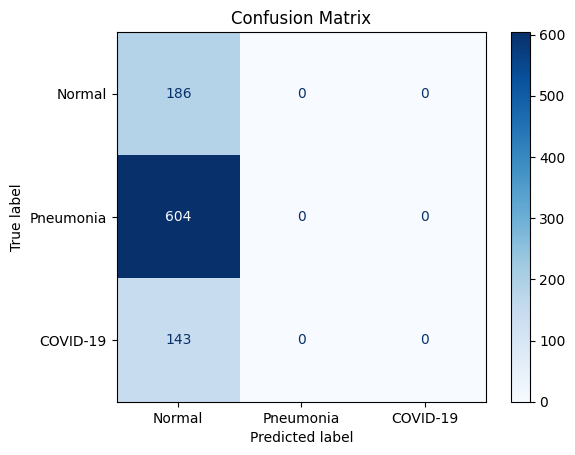

In [23]:
# loss, accuracy = model.evaluate(val_generator, steps=len(val_generator))
accuracy = accuracy_score(agent_val_label, val_predicted_labels)

# Calculate precision
precision = precision_score(agent_val_label, val_predicted_labels, average='micro')

# Calculate F1 score
f1 = f1_score(agent_val_label, val_predicted_labels, average='micro')

# Calculate AUC-ROC
#auc_roc = roc_auc_score(agent_val_label, val_predictions, average='micro')

# Calculate confusion matrix
# conf_matrix = multilabel_confusion_matrix(val_labels, val_predicted_labels)
conf_matrix = confusion_matrix(agent_val_label, val_predicted_labels)

print("Accuracy:", accuracy)
# print("Loss:", loss)
print("Precision:", precision)
print("F1 Score:", f1)
#print("AUC-ROC Score:", auc_roc)
print("Confusion Matrix:\n", conf_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [28]:
model_name = "./models/xray_final_"  + "acc_" + str(round(accuracy * 100, 1)) + ".h5"
model.save_weights(model_name)